## INSTALLING LIBROSA FOR HANDLING AUDIO DATA

In [111]:
!pip install librosa



## Step 1: Installing required Dependencies

In [1]:
#import dependencies
import numpy as np
import pandas
import os
import librosa
import librosa.display
import IPython.display as ipd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob  

## Step 2: Creating CustomDataset architecture (converting audio to tensors data which we can work with) 

In [3]:
class CustomDataset(Dataset):
    def __init__(self, directory, sample_rate=22050, duration=4, transform=None):
        super().__init__()
        self.transform = transform
        self.sample_rate = sample_rate
        self.duration = duration
        self.dir = directory
        self.items = glob.glob(os.path.join(directory, '*.wav'))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        audio_path = self.items[idx]
        waveform, rate_in = librosa.load(audio_path, sr=self.sample_rate, duration=self.duration)
        if self.transform:
            waveform = self.transform(waveform, rate_in)  # Pass rate_in to transform function
        return waveform

def audio_transform(waveform, rate_in=22050, rate_out=16000):
    # Resample the waveform
    waveform_resampled = librosa.resample(waveform, orig_sr=rate_in, target_sr=rate_out)
    
    # Apply Short Time Fourier Transform (STFT)
    stft = librosa.stft(waveform_resampled)
    
    # Convert to decibel (log scale)
    stft_db = librosa.amplitude_to_db(np.abs(stft))
    
    # Convert to PyTorch tensor
    stft_tensor = torch.tensor(stft_db)
    
    return stft_tensor
directory=r'data_2/Parsed_Capuchinbird_Clips'
directory_2=r'data_2/Parsed_Not_Capuchinbird_Clips'
dataset_positive = CustomDataset(directory=directory, transform=audio_transform)
dataset_negatives = CustomDataset(directory=directory_2, transform=audio_transform)

torch.Size([1025, 79])
torch.Size([1025, 96])


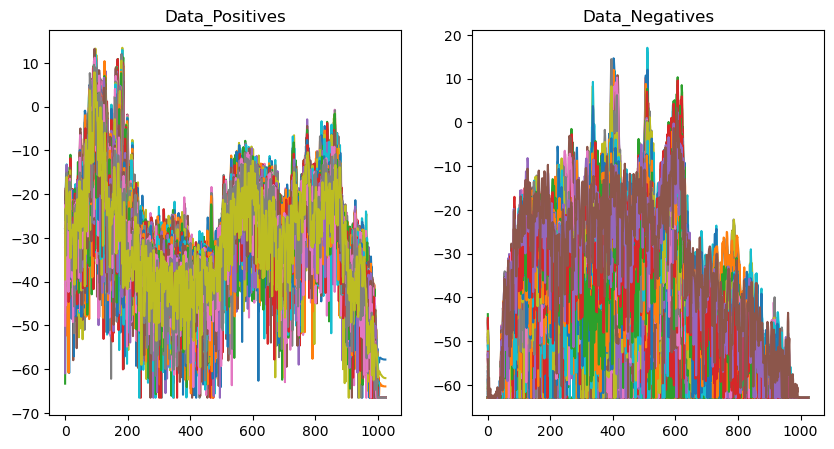

In [4]:

for x,y in zip(dataset_positive,dataset_negatives):
    fig ,ax=plt.subplots(1,2,figsize=(10,5))
    print(x.shape)
    ax[0].plot(x)
    ax[0].set_title("Data_Positives")
    print(y.shape)
    ax[1].plot(y)
    ax[1].set_title("Data_Negatives")
    break
   


In [5]:
count=0
sum=0
for x in dataset_positive:
    count+=1
    sum+=x.shape[1]
avg_length_pos=int(sum/count)
for x in dataset_negatives:
    count+=1
    sum+=x.shape[1]
avg_length_neg=int(sum/count)

print(avg_length_pos,avg_length_neg)

105 99


## Step 3 : Resizing all the data into same size to feed in into neural network architecture

In [6]:
import torch
data_pos=[]
data_neg=[]

# Calculate the average size along the second dimension
avg_size = 105
# Truncate and pad tensors to match the average size along the second dimension
for i, x in enumerate(dataset_positive):
    new_size = min(x.size(1), avg_size)  # Choose the minimum of current size and average size
    data_pos.append(torch.nn.functional.pad(x[:, :new_size], (0, avg_size-new_size), value=0))
    #dataset_negatives[i] = torch.nn.functional.pad(y[:, :new_size], (0, avg_size - new_size), value=0)
for i, x in enumerate(dataset_negatives):
    new_size = min(x.size(1), avg_size)  # Choose the minimum of current size and average size
    data_neg.append(torch.nn.functional.pad(x[:, :new_size], (0, avg_size-new_size), value=0))


In [7]:
i=0
while i<4:
    print(data_pos[i].shape, data_neg[i].shape)
    i+=1

torch.Size([1025, 105]) torch.Size([1025, 105])
torch.Size([1025, 105]) torch.Size([1025, 105])
torch.Size([1025, 105]) torch.Size([1025, 105])
torch.Size([1025, 105]) torch.Size([1025, 105])


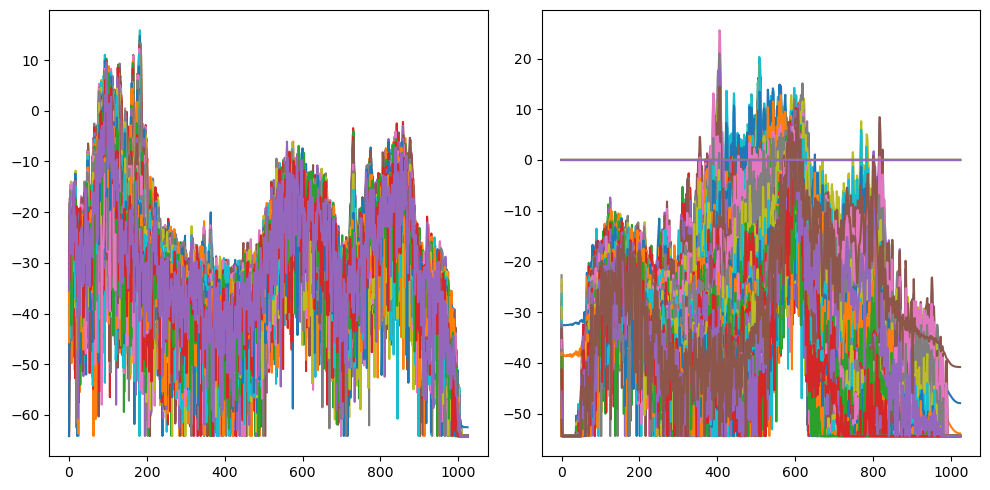

In [8]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(data_pos[2])
ax[1].plot(data_neg[2])

plt.tight_layout()
plt.show()

## Step 4 : Visualizing our audio data for positives and negatives (diff easily observable) 

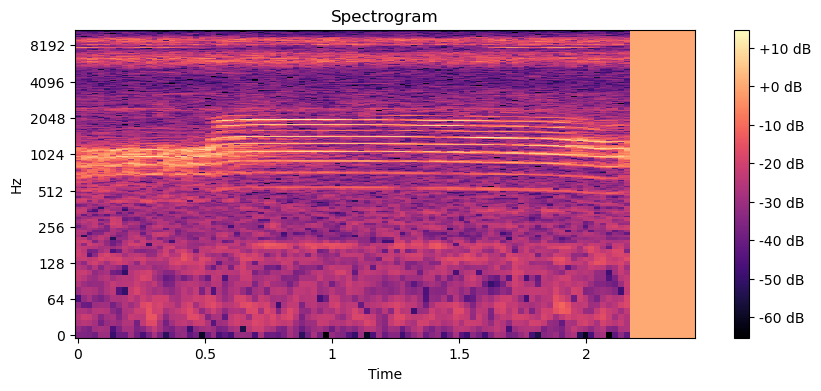

In [9]:
plt.figure(figsize=(10, 4))
data_pos=data_pos[3].numpy()
librosa.display.specshow(data_pos, sr=22050, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

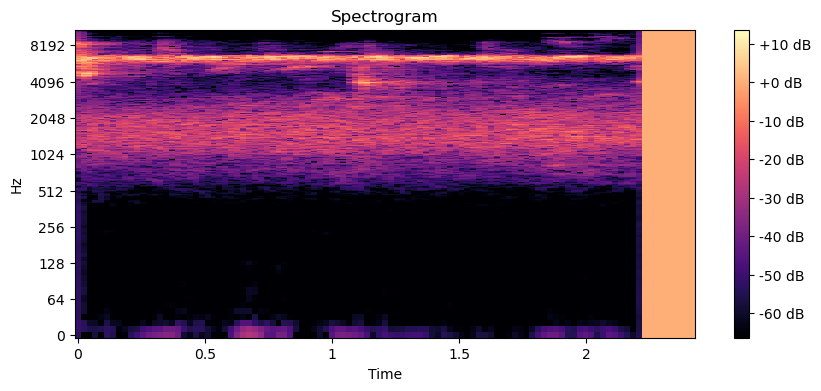

In [10]:
plt.figure(figsize=(10, 4))
data_neg=data_neg[3].numpy()
librosa.display.specshow(data_neg, sr=22050, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## Step 5: Partitioning Data into train ,test along with assigning with appro. lables

In [11]:
from torch.utils.data import ConcatDataset

In [12]:
labels_pos=[]
labels_neg=[]
for i in range (1025):
    labels_neg.append(0)
    labels_pos.append(1)

data_pos_t=torch.tensor(data_pos).float()
data_neg_t=torch.tensor(data_neg).float()
label_pos_t=torch.tensor(labels_pos).float()
label_neg_t=torch.tensor(labels_neg).float()

Data_train_1,Data_test_1,Data_labels_1,Test_labels_1=train_test_split(data_pos_t,label_pos_t,train_size=0.8)
train_dataset_1=TensorDataset(Data_train_1,Data_labels_1)
test_dataset_1=TensorDataset(Data_test_1,Test_labels_1)

Data_train_2,Data_test_2,Data_labels_2,Test_labels_2=train_test_split(data_neg_t,label_neg_t,train_size=0.8)
train_dataset_2=TensorDataset(Data_train_2,Data_labels_2)
test_dataset_2=TensorDataset(Data_test_2,Test_labels_2)

train_dataset=ConcatDataset([train_dataset_2,train_dataset_1])
test_dataset=ConcatDataset([test_dataset_2,test_dataset_1])

In [13]:
train_loader=DataLoader(train_dataset,shuffle=True,batch_size=64,drop_last=True)
test_loader=DataLoader(test_dataset,shuffle=False,batch_size=32,drop_last=True)

for x,y in train_loader:
    print("TRAIN_LOADER")
    print(x.shape,y.shape)
    print('')
    break
for x,y in test_loader:
    print("TEST_LOADER")
    print(x.shape,y.shape)
    break

TRAIN_LOADER
torch.Size([64, 105]) torch.Size([64])

TEST_LOADER
torch.Size([32, 105]) torch.Size([32])


# Step 6: Constructing neural network architecture using class definition(flexible)

In [14]:
#architecture
def arc():
    class spec(nn.Module):
        def __init__ (self,hidden_units,hidden_layers):
            super().__init__()
            self.hidden=hidden_units
            self.hidd_layers=hidden_layers
            self.input=nn.Linear(105,hidden_units)
            self.layers=nn.ModuleDict()
            self.output=nn.Linear(hidden_units,1)
            
            for i in range (hidden_layers):
                self.layers[f'{i}']=nn.Linear(hidden_units,hidden_units)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            for i in range (self.hidd_layers):
                x=F.relu(self.layers[f'{i}'](x))
            x=self.output(x)
            
            
            return x
    net=spec(4,2)
    lossf=nn.BCEWithLogitsLoss()
    optim=torch.optim.Adam(net.parameters(),lr=0.001,weight_decay=0.0001)
    return net,lossf,optim

            

# Step 7: Passing demi data to check the network and then creating a fucnction to train the model

In [15]:
#demi data
net,lossfun,optim=arc()

x,y =next(iter(train_loader))
for x,y in train_loader:
    yhat=net(x)
    y=y.unsqueeze(1)
    print(f'Output_data  {yhat.shape},Input_data  {x.shape}')
    break

Output_data  torch.Size([64, 1]),Input_data  torch.Size([64, 105])


In [34]:
#train
def train():
    net,lossfun,optim=arc()
    epochs=100
    
    losses_batch_train=[]
    accuracy_batch_train=[]
    
    pred=[]
    losses_batch_test=[]
    losses_test=[]
    accuracy_batch_test=[]
    accuracy_test=[]
    
    for epochi in range(epochs):
        
        for x,y in train_loader:
            net.train()
            losses=[]
            accuracy=[]
            
            yhat=net(x)
            y=y.unsqueeze(1)
            loss=lossfun(yhat,y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.item())
            accuracy.append(torch.mean(torch.tensor((yhat>0.5)==y).float()).item())
        
        losses_batch_train.append(torch.mean(torch.tensor(losses)))
        accuracy_batch_train.append(100*(torch.mean(torch.tensor(accuracy))))
        
        for x, y in  test_loader:
                net.eval()
                losses=[]
                accuracy=[]
                
            
                yhat=net(x)
                pred.append(yhat)
                y=y.unsqueeze(1)
                loss=lossfun(yhat,y)

            
                losses.append(loss.item())
                accuracy.append(torch.mean(torch.tensor((yhat>0.5)==y).float()).item())
        
        losses_batch_test.append(torch.mean(torch.tensor(losses)))
        accuracy_batch_test.append(100*(torch.mean(torch.tensor(accuracy))))
    return net,losses_batch_train,losses_batch_test,accuracy_batch_train,accuracy_batch_test,pred

    
    

In [79]:
net_1,losses_batch_train,losses_batch_test,accuracy_batch_train,accuracy_batch_test,pred=train()

C:\Users\Chiranjeet\AppData\Local\Temp\ipykernel_2856\3170098584.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accuracy.append(torch.mean(torch.tensor((yhat>0.5)==y).float()).item())
C:\Users\Chiranjeet\AppData\Local\Temp\ipykernel_2856\3170098584.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accuracy.append(torch.mean(torch.tensor((yhat>0.5)==y).float()).item())


# Step 8: Visualising the losses (right),accuracy(left)

[]

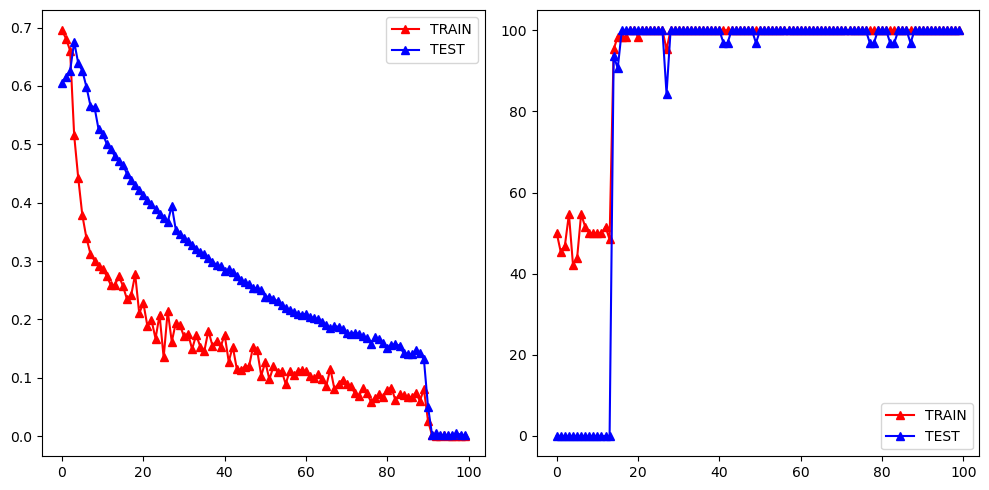

In [80]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(losses_batch_train,'r^-')
ax[0].plot(losses_batch_test,'b^-')
ax[0].legend(["TRAIN","TEST"])
ax[1].plot(accuracy_batch_train,'r^-')
ax[1].plot(accuracy_batch_test,'b^-')
ax[1].legend(["TRAIN","TEST"])
plt.tight_layout()
plt.plot()

# Step 9 : Creating arrangements to play audio of random data and showing the model results 
        1)install dependencies and import them
        2)convert single test audios to data
        3)test them and show 

In [19]:
!pip install sounddevice

In [100]:
 import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset

# Define the audio transformation function
def audio_transform(waveform, rate_in=22050, rate_out=16000):
    # Resample the waveform
    waveform_resampled = librosa.resample(waveform, orig_sr=rate_in, target_sr=rate_out)

    # Apply Short Time Fourier Transform (STFT)
    stft = librosa.stft(waveform_resampled)

    # Convert to decibel (log scale)
    stft_db = librosa.amplitude_to_db(np.abs(stft))

    # Convert to PyTorch tensor
    stft_tensor = torch.tensor(stft_db)

    return stft_tensor

class CustomDataset_for_testing(Dataset):
    def __init__(self, audio_path, sample_rate=22050, duration=4, transform=None):
        super().__init__()
        self.transform = transform
        self.sample_rate = sample_rate
        self.duration = duration
        self.audio_path = audio_path
        self.load_audio()

    def load_audio(self):
        self.waveform, _ = librosa.load(self.audio_path, sr=self.sample_rate, duration=self.duration)

    def __len__(self):
        return 1  # We only have one audio file

    def __getitem__(self, idx):
        self.load_audio()  # Reload the audio every time __getitem__ is called to ensure freshness
        waveform = self.waveform
        
        if self.transform:
            waveform = self.transform(waveform)  # Apply the transform function once
            
        return waveform

# Example usage:
directory_false = r'data_2/testing/afternoon-birds-song-in-forest-30.wav'      
directory = r'data_2/testing/XC3776-5.wav'

# Initialize datasets with transformations
data_true = CustomDataset_for_testing(audio_path=directory, transform=audio_transform)
data_false = CustomDataset_for_testing(audio_path=directory_false, transform=audio_transform)


In [101]:


data_up = []
data_down = []
avg_size = 105

for index, x in enumerate(data_true):
    new_size = min(x.shape[1], avg_size)  # Choose the minimum of current size and average size
    padded_tensor = torch.nn.functional.pad(x[:, :new_size], (0, avg_size - new_size), value=0)
    data_up.append(padded_tensor)
    break
for index, x in enumerate(data_false):
    new_size = min(x.shape[1], avg_size)  # Choose the minimum of current size and average size
    padded_tensor = torch.nn.functional.pad(x[:, :new_size], (0, avg_size - new_size), value=0)
    data_down.append(padded_tensor)
    break


In [104]:
data_up

[tensor([[-28.0780, -34.5183, -38.4286,  ...,   0.0000,   0.0000,   0.0000],
         [-27.8892, -38.0488, -38.4286,  ...,   0.0000,   0.0000,   0.0000],
         [-25.4160, -30.6618, -38.4286,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [-38.4286, -38.4286, -38.4286,  ...,   0.0000,   0.0000,   0.0000],
         [-38.4286, -38.4286, -38.4286,  ...,   0.0000,   0.0000,   0.0000],
         [-38.4286, -38.4286, -38.4286,  ...,   0.0000,   0.0000,   0.0000]])]

In [105]:
data_down

[tensor([[-50.1839, -56.4117, -64.3217,  ...,   0.0000,   0.0000,   0.0000],
         [-50.2197, -55.9140, -64.3217,  ...,   0.0000,   0.0000,   0.0000],
         [-50.2603, -56.4946, -64.3217,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [-60.8229, -64.3217, -64.3217,  ...,   0.0000,   0.0000,   0.0000],
         [-60.8276, -64.3217, -64.3217,  ...,   0.0000,   0.0000,   0.0000],
         [-60.8290, -64.3217, -64.3217,  ...,   0.0000,   0.0000,   0.0000]])]

In [106]:
pred_1=[]
pred_2=[]
for x,y in zip(data_up,data_down):
    pred_1.append(torch.mean(net_1(x))>0)
    pred_2.append(torch.mean(net_1(y))>0)
pred_1

[tensor(True)]

In [107]:
pred_2

[tensor(False)]

In [113]:
import sounddevice as sd
audio_true='data_2/testing/XC3776-5.wav'
y,sr=librosa.load(audio_true)
sd.play(y)
print(f'Result via Model{pred_1}')



Result via Model[tensor(True)]


In [114]:
audio_false='data_2/testing/afternoon-birds-song-in-forest-5.wav'
y,sr=]
sd.play(y)
print(f'Result via Model{pred_2}')

Result via Model[tensor(False)]


## Hence , the results are indeed true so we are done with our audio classification project